# Aprendizaje Automatico - TP 1

In [182]:
%matplotlib inline

In [183]:
import os

In [184]:
import numpy as np
from scipy.sparse import coo_matrix
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.float_format = '{:g}'.format
plt.rcParams['figure.figsize'] = 14, 5

In [185]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest, chi2, RFE, SelectFromModel
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.decomposition import TruncatedSVD
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.cross_validation import cross_val_score

In [186]:
import features as cf
from util import *

Cargamos el dataset, lo convertimos a un pandas DataFrame y separamos en set de entrenamiento y de test

In [6]:
# Por reproducibilidad, y para no perder tiempo armando el DataFrame cada vez, lo bajamos a
# un archivo la priemra vez que lo corrimos, ya seprando 20% para reportar como valor final
# de nuestro modelo
train_set_name = 'dataset/train_set.pkl'
test_set_name = 'dataset/test_set.pkl'
train_set = None
test_set = None

if os.path.isfile(train_set_name) and os.path.isfile(test_set_name):
    print 'Loading Train Set'    
    train_set = print_time(lambda: joblib.load(train_set_name))
    print ''
        
    print 'Loading Test Set'
    test_set = print_time(lambda: joblib.load(test_set_name))
    print ''
else:
    train_set, test_set = load_raw_data()
    print ''
    
    print 'Saving Train Set'
    print_time(lambda: joblib.dump(train_set, train_set_name, compress=True))
    print ''
    
    print 'Saving Test Set'
    print_time(lambda: joblib.dump(test_set, test_set_name, compress=True))
    print ''

Loading Train Set
Done in 1.885000s

Loading Test Set
Done in 0.482000s



In [7]:
print_sets_summarys(train_set, test_set)

Train Set: 72000 samples - ham: 35997(0.50%) spam: 36003(0.50%)
Test Set:  18000 samples - ham: 9003(0.50%) spam: 8997(0.50%)


## Exploración de datos

Vamos a explorar un poco los datos. Primero inspeccionamos los primeros mails del set de entrenamiento, para ver que pinta tienen.

In [8]:
train_set.head()

,content_types,subject,body,label
0,[text/html],penny st0ck booms on continued demand,\r\n\r\n\r\n\r\n\r\npenny st0ck booms on conti...,spam
1,[text/plain],RE: BNP Paribas Master Netting Agreement,The receivables deal has been terminated. Feel...,ham
2,[text/plain],I NEED YOU TO ACT AS THE NEXT OF KIN TO LATE M...,"\n\n \n \nATTN:THE DIRECTOR /CEO,\n\nAN URGENT...",spam
3,[text/plain],WTI-Brent,Jeff -\nDon't know if WTI-Brent is on the new ...,ham
4,[text/plain],Mrs maureen clark,"\nDear Beloved in Christ,\n\nIt is by the grac...",spam


Ahora, generaremos la matriz de atributos (unigramas y bigramas) TF-IDF sobre el cuerpo de los mails, y usando tres técnicas de reducción de dimensionalidad, visualizaremos los 2 atributos más importantes. Las técnicas son:
    - Elegir los 2 atributos que son mas probables(segun un test chi2) que sean dependientes de la etiqueta
    - Eliminar recursivamente los atributos que menor peso tengan asignados por un clasificador SVM lineal
    - Entrenar un clasificador SVM lineal con penalizacion l1(fuerza esparcidad, gran cantidad de pesos en 0), y elegir los 2 atributos que mas importancia tengan 
Para visualizar, mostramos un gráfico con el valor de cada uno de los 2 atributos en los ejes, y la clase como color. Tambien mostramos un histograma por cada atributo, agrupando por la clase.

In [221]:
def plot_2_best_features(feature_selector, tokens, token_names, labels):
    if feature_selector == 'k_best':
        transformer = SelectKBest(chi2, k=2)
        selected_tokens = transformer.fit_transform(tokens, labels)
        feature1_name, feature2_name = [token_names[i] for i in transformer.get_support(indices=True)]
    elif feature_selector == 'rfe':
        transformer = RFE(LinearSVC(), n_features_to_select=2)
        selected_tokens = transformer.fit_transform(tokens, labels)
        feature1_name, feature2_name = [token_names[i] for i in transformer.get_support(indices=True)]
    elif feature_selector == 'l1':
        svc = LinearSVC(penalty="l1", dual=False).fit(tokens, labels)
        ind = np.argpartition(svc.coef_[0], -2)[-2:]
        ind = ind[np.argsort(svc.coef_[0, ind])][::-1]
        selected_tokens = tokens[:, ind]
        feature1_name, feature2_name = [token_names[i] for i in ind]
    else:
        raise ValueError('Invalid feature_selector. Expected None, \'k_best\', \'pca\' or \'l1\'')

    print 'Visualizing using feature selector %s' % feature_selector
    title = 'Features selected using %s' % feature_selector
    
    df = pd.DataFrame(selected_tokens.todense(), columns=[feature1_name, feature2_name])
    df['label'] = labels
    
    df.plot(kind='scatter',
            x=feature1_name,
            y=feature2_name,
            figsize=(10, 5),
            title=title,
            c=['blue' if label == 'ham' else 'red' for label in labels])
    
    df = df.sample(1000)
    
    fig, axs = plt.subplots(ncols=2)
    title = 'Feature \'%s\' frequency by class in 1000 random samples'
    
    df.groupby('label')[feature1_name].plot(kind='hist',
                                            ax=axs[0],
                                            title=title % feature1_name,
                                            legend=True, alpha=0.4)
    df.groupby('label')[feature2_name].plot(kind='hist',
                                            ax=axs[1],
                                            title=title % feature2_name,
                                            legend=True, alpha=0.4)
    fig.show()
    

def show_selectors_bests_features(mails):
    tfidf = TfidfVectorizer(stop_words='english',
                                    ngram_range=(1, 2),
                                    strip_accents='ascii',
                                    sublinear_tf=True)
    mail_body_tokens = tfidf.fit_transform(mails.body)
    token_names = tfidf.get_feature_names()
    plot_2_best_features('k_best', mail_body_tokens, token_names, mails.label)
    plot_2_best_features('rfe', mail_body_tokens, token_names, mails.label)
    plot_2_best_features('l1', mail_body_tokens, token_names, mails.label)

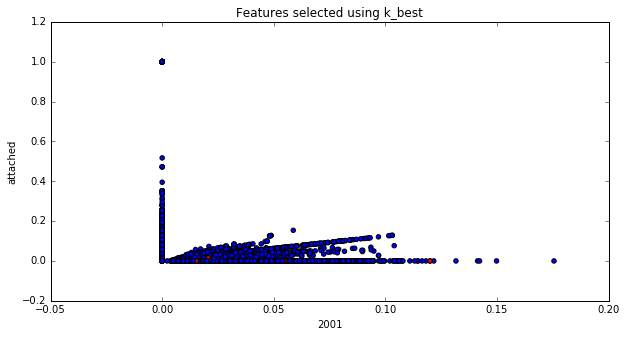

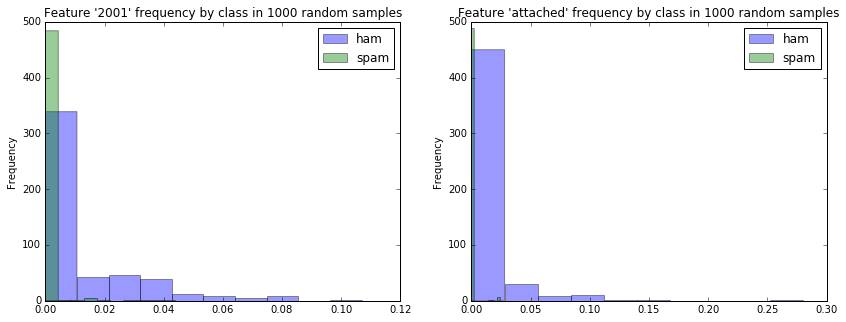

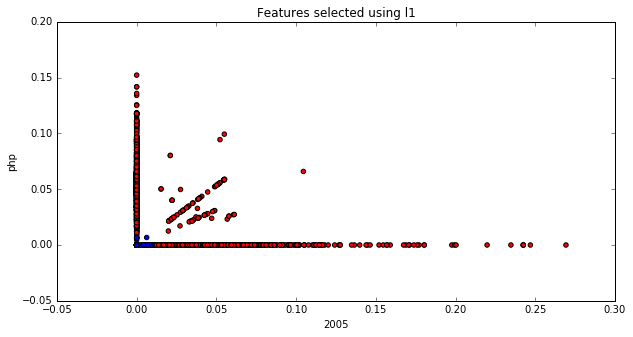

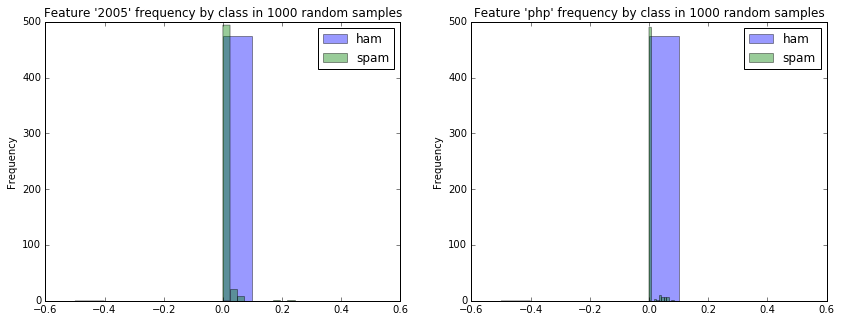

In [222]:
show_selectors_bests_features(train_set)

## Atributos
Definimos los siguientes atributos a ser extraidos de cada mail:
1. Atributos simples:
    - Longitud del asunto
    - Cantidad de espacios en el asunto dividido por la longitud del asunto
    - Cantidad de caracteres mayusculas en el asunto dividido por la longitud del asunto
    - Longitud del cuerpo
    - Cantidad de espacios en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de caracteres mayusculas en el cuerpo dividido por la longitud del cuerpo
    - Cantidad de oraciones del cuerpo
    - Tiene el mail contenido HTML?
    - Tiene el mail imágenes?
2. Atributos de vectorizacion del asunto: cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece(TF-IDF)
3. Atributos de vectorizacion del cuerpo: cantidad de apariciones por token dividido por la cantidad de documentos en los que aparece(TF-IDF)

In [10]:
def simple_extractors():
    return cf.SimpleFeaturesExtractor([('subject_length', cf.subject_length), 
        ('subject_spaces', cf.subject_spaces), 
        ('subject_caps', cf.subject_caps),
        ('body_length', cf.body_length), 
        ('body_spaces', cf.body_spaces), 
        ('body_caps', cf.body_caps), 
        ('body_sentences', cf.body_sentences),
        ('has_html', cf.has_html), 
        ('has_image', cf.has_image)
      ])
def vectorizer_extractor(feature_selector):
    if feature_selector is None:
        return [('vectorizer', TfidfVectorizer(stop_words='english', 
                           ngram_range=(1, 2),
                           strip_accents='ascii',
                           sublinear_tf=True,
                           min_df=0.001,
                           max_df=0.7))]
    elif feature_selector == 'k_best':
        return [('vectorizer', TfidfVectorizer(stop_words='english', ngram_range=(1, 2),
                           strip_accents='ascii',
                           sublinear_tf=True,
                            min_df=0.0001,
                           max_df=0.95
                ('k_best', SelectKBest(chi2, k=2))]
    elif feature_selector == 'pca':
        return [('vectorizer', TfidfVectorizer(stop_words='english', 
                           ngram_range=(1, 2),
                           strip_accents='ascii',
                           sublinear_tf=True,
                           min_df=0.0001,
                           max_df=0.95)),
                ('pca', TruncatedSVD(n_components=50))]    
    elif feature_selector == 'l1':
        return [('vectorizer', TfidfVectorizer(stop_words='english', 
                           ngram_range=(1, 2),
                           strip_accents='ascii',
                           sublinear_tf=True,
                           min_df=0.0001,
                           max_df=0.95)),
                ('svd', LinearSVC(C=1.0))]
    else
        raise ValueError('Invalid feature_selector. Expected None, \'k_best\', \'pca\' or \'lasso\')
        

Sobre los atributos de vectorizacion, damos la posiblidad de aplicar LSA, agregando PCA(tecnicamente, TruncatedSVD, pero a fines practicos es lo mismo) al pipeline correspondiente

In [10]:
def features_extractors(simple_features=True, subject_vectorizer=True, subject_lsa=True, body_vectorizer=True, body_lsa=True):
    extractors = []
    
    if simple_features:
        # Extractor de atributos simples
        extractors = [('simple_features', simple_extractors())]
    
    if subject_vectorizer:
        # Pipeline para extraer atributos de vectorizacion del asunto del mail
        extractors = extractors + \
                [('subject', Pipeline([
                    ('selector', ColumnSelectorExtractor('subject'))] + vectorizer_extractor(lsa=subject_lsa, lsa_components=20)
                ))]

    if body_vectorizer:
        # Pipeline para extraer atributos de vectorizacion del cuerpo del mail
        extractors = extractors + \
                [('body', Pipeline([
                    ('selector', ColumnSelectorExtractor('body'))] + vectorizer_extractor(lsa=body_lsa, lsa_components=50)
                ))]

    # Use FeatureUnion to combine the features
    return FeatureUnion(extractors)

def features_extractors_name(simple_features=True, subject_vectorizer=True, subject_lsa=True, body_vectorizer=True, body_lsa=True):
    names = []
    
    if simple_features:
        names = ['simple']
    
    if subject_vectorizer:
        if subject_lsa:
            names.append('subject_lsa')
        else:            
            names.append('subject_vectorizer')
            
    if body_vectorizer:
        if body_lsa:
            names.append('body_lsa')
        else:
            names.append('body_vectorizer')
            
    return '_'.join(names)

### Evaluación de modelos

Probamos distintas configuracions de atributos y clasificadores, obteniendo para cada uno sus puntajes de 10-fold CV

In [ ]:
parameters_grid = {
    'tree_classifier__max_features': ['sqrt', 'log2', 0.5, None],
    'tree_classifier__max_depth': [3, 5, 10, None],
    'tree_classifier__min_samples_split': [1, 3, 5, 10],
    'tree_classifier__min_samples_leaf': [1, 3, 5, 10]
}

dt = GridSearchCV(Pipeline([
  ('features_extractor', features_extractors(False, False, False)),
  ('tree_classifier', DecisionTreeClassifier())
]), parameters_grid, n_jobs=4, verbose=2)

#### Decision Tree

In [34]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(False, False, False)),
  ('tree_classifier', DecisionTreeClassifier(max_features='sqrt', max_depth=None))
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   48.5s finished


array([ 0.93483333,  0.93383333,  0.92895833])

In [13]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(False, False, False)),
  ('tree_classifier', DecisionTreeClassifier(max_features='log2', max_depth=None))
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   48.6s finished


array([ 0.929     ,  0.92966667,  0.93204167])

In [14]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(False, False, False)),
  ('tree_classifier', DecisionTreeClassifier(max_features=0.5, max_depth=None))
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   49.3s finished


array([ 0.93270833,  0.93745833,  0.936375  ])

In [15]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(False, False, False)),
  ('tree_classifier', DecisionTreeClassifier(max_features=None, max_depth=None))
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   50.9s finished


array([ 0.93608333,  0.93345833,  0.93379167])

In [16]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(False, False, False)),
  ('tree_classifier', DecisionTreeClassifier(max_features=None, max_depth=10))
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   51.0s finished


array([ 0.93825   ,  0.93570833,  0.93941667])

#### Random Forests

In [39]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(False, False, False, True, False)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   51.1s finished


array([ 0.96041667,  0.95933333,  0.9605    ])

In [36]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(False, False, False, True, True)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   50.9s finished


array([ 0.958125  ,  0.95791667,  0.95504167])

In [40]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(True, False, False, True, False)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min finished


array([ 0.98529167,  0.98491667,  0.984625  ])

In [23]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(True, False, False, True, True)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.5min finished


array([ 0.98258333,  0.98241667,  0.98216667])

In [35]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(True, True, True, True, True)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min finished


array([ 0.98266667,  0.98304167,  0.98229167])

In [41]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(True, True, False, True, False)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min finished


array([ 0.98533333,  0.98570833,  0.98479167])

In [42]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(True, True, True, True, False)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min finished


array([ 0.97858333,  0.97908333,  0.97925   ])

In [43]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(True, True, False, True, True)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:  1.6min finished


array([ 0.981875  ,  0.98320833,  0.98091667])

In [ ]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(False, True, False, False, False)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

In [ ]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(False, True, True, False, False)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

In [ ]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(True, True, False, False, False)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

In [37]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(True, True, True, False, False)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=3, verbose=2)

[Parallel(n_jobs=3)]: Done   3 out of   3 | elapsed:   50.2s finished


array([ 0.94495833,  0.94866667,  0.9465    ])

In [ ]:
cross_val_score(Pipeline([
  ('features_extractor', features_extractors(True, True, True, True, True)),
  ('tree_classifier', RandomForestClassifier())
]), train_set, train_set['label'], n_jobs=2, verbose=2)